# Solución Laboratorio: Integración Numérica y EDOs
**Métodos:** Riemann, Trapecio, Simpson y Heun.

## 1. Aproximación de la Integral
$$ I = \int_{-1}^{1} |x|e^{x} dx $$
Se separa el intervalo en $[-1, 0]$ (donde $|x|=-x$) y $[0, 1]$ (donde $|x|=x$).

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.special import erf 


def f(x):
    return np.abs(x) * np.exp(x)


def riemann_particionado(a, b, n, tipo='superior'):
    
    
    nodes_left = np.linspace(-1, 0, n // 2 + 1)
    nodes_right = np.linspace(0, 1, n // 2 + 1)
    
    h = 2 / n 
    val = 0
    
  
    if tipo == 'superior':
        
        sum_left = np.sum(f(nodes_left[:-1]))
        sum_right = np.sum(f(nodes_right[1:]))
    else: 
        
        sum_left = np.sum(f(nodes_left[1:]))
        sum_right = np.sum(f(nodes_right[:-1]))
        
    return h * (sum_left + sum_right)

# Calculamos para un N ejemplo
N_riemann = 5000
I_sup = riemann_particionado(-1, 1, N_riemann, 'superior')
I_inf = riemann_particionado(-1, 1, N_riemann, 'inferior')
print(f"Riemann Superior (N={N_riemann}): {I_sup:.6f}")
print(f"Riemann Inferior (N={N_riemann}): {I_inf:.6f}")

Riemann Superior (N=5000): 1.264858
Riemann Inferior (N=5000): 1.263624


## Conclusiones 


**a) Independencia de Sumas Superiores/Inferiores:**
La función $f(x)=|x|e^x$ es continua en todo el intervalo $[-1, 1]$. Por teorema, para cualquier función continua en un intervalo cerrado, tanto las sumas de Riemann superiores como las inferiores convergen al mismo valor exacto de la integral a medida que el número de particiones $n \to \infty$. La elección es irrelevante para el resultado límite, aunque para un $n$ finito, el promedio de ambas (Trapecio) suele ser mejor estimador.

## 1b y 1c. Métodos Numéricos y Análisis de Convergencia
Métodos: Punto Medio, Trapecio, Simpson 1/3.
Objetivo: Encontrar $N$ para obtener 7 decimales de precisión.

Valor Exacto (Quad): 1.264241118

Nodos necesarios para error < 1e-7:
Punto Medio: N = 2394 (Valor: 1.26424102)
Trapecio: N = 3386 (Valor: 1.26424122)
Simpson: N = 48 (Valor: 1.26424121)


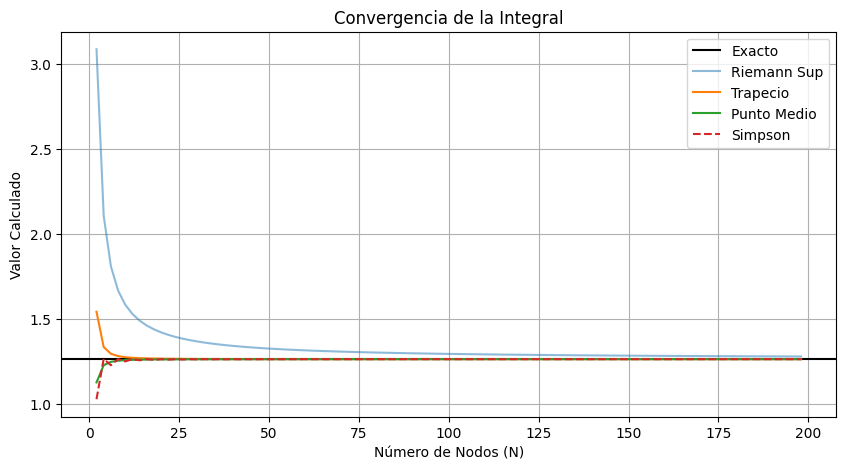

In [5]:
# --- DEFINICIÓN DE MÉTODOS ---
def punto_medio(func, a, b, n):
    h = (b - a) / n
    x = np.linspace(a + h/2, b - h/2, n)
    return h * np.sum(func(x))

def trapecio(func, a, b, n):
    x = np.linspace(a, b, n + 1)
    y = func(x)
    h = (b - a) / n
    return (h/2) * (y[0] + 2*np.sum(y[1:-1]) + y[-1])

def simpson(func, a, b, n):
    if n % 2 != 0: n += 1
    x = np.linspace(a, b, n + 1)
    y = func(x)
    h = (b - a) / n
    return (h/3) * (y[0] + 4*np.sum(y[1:-1:2]) + 2*np.sum(y[2:-2:2]) + y[-1])


I_exact, _ = quad(f, -1, 1)
print(f"Valor Exacto (Quad): {I_exact:.9f}")

# --- BÚSQUEDA DE N PARA PRECISIÓN (7 decimales -> Error < 5e-8) ---
tol = 1e-7
methods = [punto_medio, trapecio, simpson]
names = ['Punto Medio', 'Trapecio', 'Simpson']
ns_needed = []

print("\nNodos necesarios para error < 1e-7:")
for method, name in zip(methods, names):
    n = 2
    while True:
        val = method(f, -1, 1, n)
        if abs(val - I_exact) < tol:
            print(f"{name}: N = {n} (Valor: {val:.8f})")
            ns_needed.append(n)
            break
        n += 2
        if n > 20000: 
            print(f"{name}: No convergió rápido")
            break

# --- GRÁFICA DE EVOLUCIÓN ---
N_range = range(2, 200, 2)
vals_mid = [punto_medio(f, -1, 1, n) for n in N_range]
vals_trap = [trapecio(f, -1, 1, n) for n in N_range]
vals_simp = [simpson(f, -1, 1, n) for n in N_range]
vals_riem = [riemann_particionado(-1, 1, n, 'superior') for n in N_range]

plt.figure(figsize=(10, 5))
plt.axhline(I_exact, color='k', linestyle='-', label='Exacto')
plt.plot(N_range, vals_riem, label='Riemann Sup', alpha=0.5)
plt.plot(N_range, vals_trap, label='Trapecio')
plt.plot(N_range, vals_mid, label='Punto Medio')
plt.plot(N_range, vals_simp, label='Simpson', linestyle='--')

plt.title("Convergencia de la Integral")
plt.xlabel("Número de Nodos (N)")
plt.ylabel("Valor Calculado")
plt.legend()
plt.grid(True)
plt.show()

## 2. EDO: Método de Heun
Resolver: 
$$ \begin{cases}y'(x)=xy(x)+x^{2} \\ y(0)=1\end{cases} $$
en el intervalo $(0, 1)$.

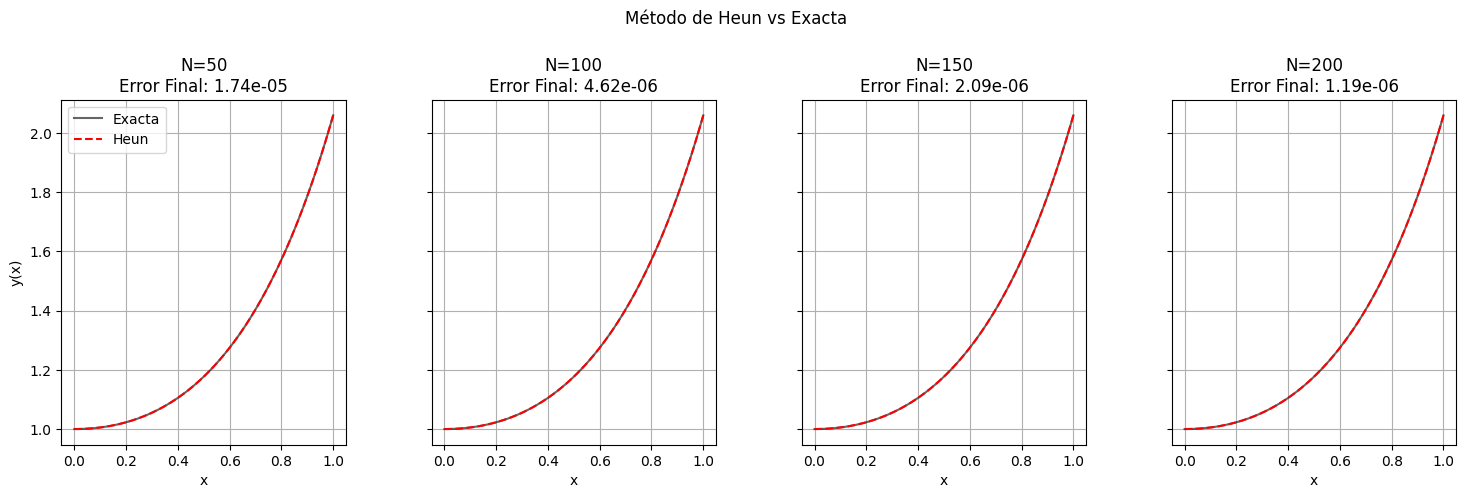

In [ ]:


def sol_exacta_edo(x):
    term1 = np.exp(x**2 / 2)
    term2 = 1 + np.sqrt(np.pi / 2) * erf(x / np.sqrt(2))
    return term1 * term2 - x

# --- MÉTODO DE HEUN ---
def heun_method(f, x0, y0, h, n_steps):
    x = np.linspace(x0, x0 + n_steps*h, n_steps + 1)
    y = np.zeros(n_steps + 1)
    y[0] = y0
    
    for i in range(n_steps):
       
        slope1 = f(x[i], y[i])
        y_pred = y[i] + h * slope1
        
        
        slope2 = f(x[i+1], y_pred)
        y[i+1] = y[i] + (h / 2) * (slope1 + slope2)
        
    return x, y

# EDO dada
def f_edo(x, y):
    return x*y + x**2

# --- GRÁFICA COMPARATIVA ---
N_values = [50, 100, 150, 200]
x_start, x_end = 0, 1
y_init = 1.0

fig, axes = plt.subplots(1, 4, figsize=(18, 5), sharey=True)
fig.suptitle("Método de Heun vs Exacta")

for idx, n in enumerate(N_values):
    h = (x_end - x_start) / n
    x_num, y_num = heun_method(f_edo, x_start, y_init, h, n)
    
    # Exacta suave
    x_smooth = np.linspace(x_start, x_end, 100)
    y_true = sol_exacta_edo(x_smooth)
    
    ax = axes[idx]
    ax.plot(x_smooth, y_true, 'k-', alpha=0.6, label='Exacta')
    ax.plot(x_num, y_num, 'r--', label='Heun')
    
    
    err_final = abs(y_num[-1] - sol_exacta_edo(1))
    
    ax.set_title(f"N={n}\nError Final: {err_final:.2e}")
    ax.set_xlabel("x")
    ax.grid(True)
    if idx == 0:
        ax.set_ylabel("y(x)")
        ax.legend()

plt.subplots_adjust(top=0.8, wspace=0.3)
plt.show()